97


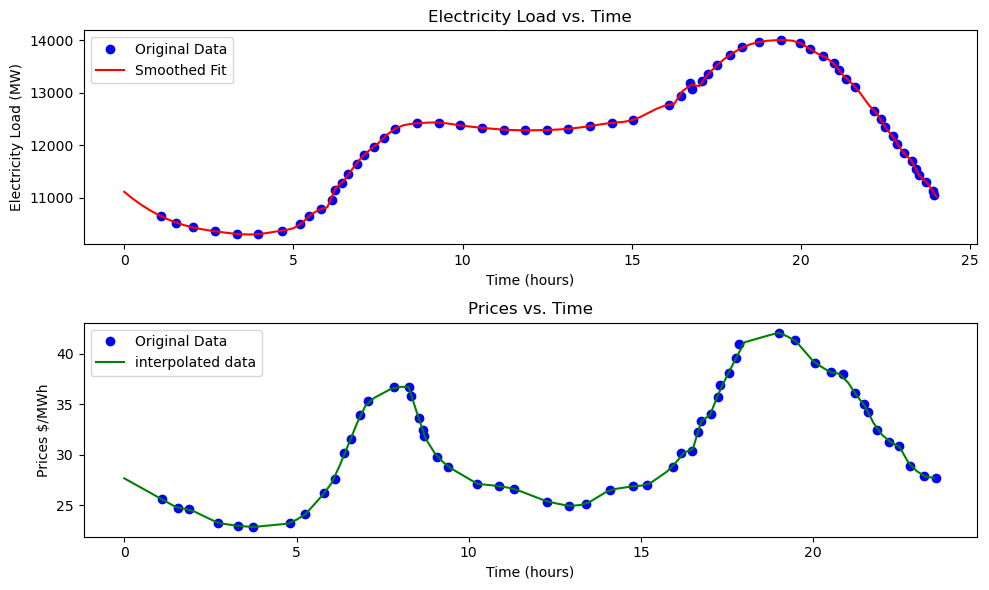

In [207]:
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Load the data from the Excel file
file_path = 'grid_restofyear_2024.xlsx'  # Replace with your actual file path
data = pd.read_excel(file_path)

# Extract columns
time1 = data['time1'].values
electricity_load = data['electricity load'].values
time2 = data['time2'].values
prices = data['prices'].values

# Define the target time steps (0.5 increments from 0 to 24)
target_times = np.arange(0, 24.25, 0.25)

# Function to apply smoothing
def smooth_fit(x, y, smoothing_factor=0.1):
    # Fit a smoothing spline to the data
    spline = UnivariateSpline(x, y, s=smoothing_factor * len(x))
    return spline(target_times), spline

# Smooth the electricity load and prices
smoothed_load, load_spline = smooth_fit(time1, electricity_load)
#smoothed_prices, prices_spline = smooth_fit(time2, prices)

def interpolate_and_extrapolate(x, y):
    interpolator = interp1d(x, y, kind='linear', fill_value='extrapolate')
    return interpolator(target_times)

# Interpolate/extrapolate electricity load and prices
interpolated_load = interpolate_and_extrapolate(time1, electricity_load)
interpolated_prices = interpolate_and_extrapolate(time2, prices)

print(len(smoothed_load))
# Plot the smoothed data
plt.figure(figsize=(10, 6))

# Electricity Load
plt.subplot(2, 1, 1)
plt.plot(time1, electricity_load, 'bo', label='Original Data')
plt.plot(target_times, smoothed_load, 'r-', label='Smoothed Fit')
plt.title('Electricity Load vs. Time')
plt.xlabel('Time (hours)')
plt.ylabel('Electricity Load (MW)')
plt.legend()

# Prices
plt.subplot(2, 1, 2)
plt.plot(time2, prices, 'bo', label='Original Data')
plt.plot(target_times, interpolated_prices, 'g-', label='interpolated data')
plt.title('Prices vs. Time')
plt.xlabel('Time (hours)')
plt.ylabel('Prices $/MWh')
plt.legend()

plt.tight_layout()
plt.show()



In [227]:
import math
#TYPE 1 Bus input data
n_bus_t1 = 18989 # total bus number, in units, source: https://www.fhwa.dot.gov/policyinformation/statistics/2022/mv10.cfm
n_garbage = 6800
EVpenetration_bus_t1 = 0.1
EVpenetration_garbage = 0.1
#TYPE 1 Bus battery specs
bat_cap_bus_t1 = 196 # battery capacity, in kWh, source: https://www.girardinbluebird.com/en/news-and-events/303-blue-bird-unveiling-next-generation-electric-school-bus#:~:text=The%20new%20Type%20C%20electric,next%2Dgeneration%20energy%20storage%20system.
Pcharg_bus_t1 = 80 # charging power, in kW, source: https://chargedevs.com/newswire/blue-bird-premieres-next-generation-electric-school-bus/#:~:text=The%20new%20electric%20school%20bus%20features%20a,supports%20a%20fast%2Dcharging%20rate%20of%2080%20kW.
range_bus_t1 = 130 # in miles
#Garbage truck battery specs
bat_cap_garbage = 568 # battery capacity, in kWh, source: 
Pcharg_garbage = 377 # charging power, in kW, source:
range_garbage = 275 # in miles

#discharge
avgspeed_bus_t1 = 20 #in mile/h
avgspeed_garbage = 19.1 #in mile/h
#Pdis_bus_t1= bat_cap_bus_t1 / range_bus_t1 * avgspeed_bus_t1 # in kW / h

#state of charge limits
min_SoC_bus_t1 = 0.2
max_SoC_bus_t1 = 0.95
min_SoC_garbage = 0.3
max_SoC_garbage = 0.7

#Operations schedule
file_path = 'type1_bus_ops.xlsx'  # import operations schedule
data_ops = pd.read_excel(file_path)
# Extract columns
time_ops_bus_t1 = data_ops['time'].values
idle_bus_t1 = data_ops['idle'].values
ops_schedule_bus_t1 = [1-idle_bus_t1[i] for i in range(0,len(idle_bus_t1))]

#Operations schedule
file_path = 'garbage_truck_ops.xlsx'  # import operations schedule
data_ops = pd.read_excel(file_path)
# Extract columns
time_ops_garbage = data_ops['time'].values
idle_garbage = data_ops['idle'].values
ops_schedule_garbage = [1-idle_garbage[i] for i in range(0,len(idle_garbage))]


In [228]:
import math
import numpy as np

def simulate_V2G_optimized(time_ops, ops_schedule, bat_cap, avg_speed, range_drive, P_charg,
                           min_SoC, max_SoC, price_electricity, threshold_price, tol=1):
    """
    Simulates Vehicle-to-Grid (V2G) operations with price optimization.
    """
    def max_consecutive_ones(lst):
        max_streak = current_streak = 0
        for num in lst:
            current_streak = current_streak + 1 if num == 1 else 0
            max_streak = max(max_streak, current_streak)
        return max_streak

    def find_future_minimum(prices, current_index, lookahead=8):
        """Find the minimum price in a lookahead window."""
        # Ensure the window is within bounds and return a scalar value
        window = prices[current_index:current_index + lookahead]
        return np.min(window) if len(window) > 0 else prices[current_index]  # Using np.min to ensure scalar

    P_dis = bat_cap / range_drive * avg_speed  # Power needed for driving (kW/h)
    E_t = max_SoC * bat_cap  # Initial battery energy
    dt = time_ops[1] - time_ops[0]  # Time step size
    
    # Initialize simulation state
    battery_energy_level = [E_t]
    charge_status = [0]
    power_to_grid = []
    charge_prices = []  # Track prices at which charging occurred
    to_grid_status = []

    for i in range(len(time_ops)):
        charge_t = discharge_t = to_grid = 0
        price_now = price_electricity[i % len(price_electricity)]  # Extracting scalar value
        price_next = price_electricity[(i + 1) % len(price_electricity)]  # Extracting scalar value
        ops_now = ops_schedule[i % len(ops_schedule)]

        # Energy needed for future operations
        E_t_needed_ops = max_consecutive_ones(ops_schedule[i:]) * P_dis * dt
        sufficient_charge_level = E_t_needed_ops + min_SoC * bat_cap  # Sufficient charge for upcoming operation
        charge_time_needed = max(0, (sufficient_charge_level - E_t) / P_charg)
        charge_time_steps = math.ceil(charge_time_needed / dt)

        # Find future minimum price in the next 24 hours (or a reasonable lookahead)
        future_min_price = find_future_minimum(price_electricity, i, lookahead=24)  # Scalar value

        # Decision logic
        if ops_now == 0:  # Not operational
            if E_t < sufficient_charge_level and abs(price_now - future_min_price) <= tol:
                charge_t = 1  # Charge near the minimum price for upcoming operation
                charge_prices.append(price_now)  # Record the charging price
            elif E_t < max_SoC * bat_cap and price_now < threshold_price:
                charge_t = 1  # Continue charging if electricity is cheap
                charge_prices.append(price_now)
            elif charge_prices and price_now > max(charge_prices):
                discharge_t = 1  # Discharge to grid if the price is higher than the charging price
                to_grid = 1
        else:  # Operational
            discharge_t = 1  # Discharge for operation

        # Update battery energy level with a check to prevent it from going below min_SoC * bat_cap
        delta_E = P_charg * dt * charge_t - P_dis * dt * discharge_t

        # Ensure battery energy doesn't go below the minimum allowed energy
        if delta_E > 0 and E_t + delta_E > max_SoC * bat_cap:
            # Adjust charging power to avoid exceeding max capacity
            delta_E = max_SoC * bat_cap - E_t
            charge_t = delta_E / (P_charg * dt)

        # Ensure battery energy doesn't go below min_SoC * bat_cap
        if E_t + delta_E < min_SoC * bat_cap:
            delta_E = min_SoC * bat_cap - E_t  # Prevent dropping below min SoC
            charge_t = 0  # Stop charging if it's going below min SoC

        # Update the battery energy
        E_t = max(min_SoC * bat_cap, min(max_SoC * bat_cap, E_t + delta_E))  # Ensure E_t is between min and max SoC
        battery_energy_level.append(E_t)
        charge_status.append(charge_t)

        # Update power to grid
        power_to_grid_t = (P_dis * to_grid - P_charg * charge_t)
        power_to_grid.append(power_to_grid_t)
        to_grid_status.append(to_grid)

    return time_ops, ops_schedule, charge_status[1:], battery_energy_level[1:], power_to_grid, to_grid_status

#simulate prices
def gridload_with_V2G(electricity_load, power_to_grid, EV_penetration,n_units):
    n_vehicles = EV_penetration * n_units
    V2G_power = np.array(power_to_grid)*n_vehicles/1000
    gridload_with_V2G = np.array(electricity_load) - V2G_power
    return V2G_power, gridload_with_V2G #in MWh

def calculate_V2G_gain(prices, power_to_grid, EV_penetration, n_units):
    n_vehicles = EV_penetration * n_units
    prices = np.array(prices) #in $/MWh
    power_to_grid_total = np.array(power_to_grid)*n_vehicles #in kW
    return prices/1000 * power_to_grid_total #in $

def calculate_net_impact(prices,power_to_grid,battery_energy_level,bat_cap,Pcharge,electricityprice,EV_penetration,n_units,min_SoC, max_SoC):
    n_vehicles = EV_penetration * n_units
    money_from_ops = np.nansum(np.array(prices)*np.array(power_to_grid))*0.25/1000
    fillup_cost =(battery_energy_level[-1] - battery_energy_level[0])*electricityprice/1000
    baseline_cost = (max_SoC-min_SoC)*bat_cap*electricityprice/1000
    print(f'n_units {n_units}, EV penetration {EV_penetration}, n_vehicles = {n_vehicles}')
    print(f'Daily V2G gain per vehicle {money_from_ops + fillup_cost} $/ vehicle')
    print(f'Daily baseline_cost {-1*baseline_cost} $ / vehicle')
    print(f'Daily V2G value creation for overall fleets {n_vehicles*(money_from_ops + fillup_cost + baseline_cost)} $_total')
    return n_vehicles*(money_from_ops + fillup_cost + baseline_cost)

def peak_shaving(gridload_with_V2G, electricity_load):
    return np.max(electricity_load) - np.max(gridload_with_V2G)

def CO2reduction(gridload_with_V2G, electricity_load):
    #gridloads in MW, time increments are 0.25h
    CO2_naturalgas = 402 #Kg/MWh
    return 402*(sum(np.array(gridload_with_V2G) - np.array(electricity_load)))*0.25

C:\Users\haldr\AppData\Local\Temp\ipykernel_41828\2079560403.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([f'{int(tick*100)}%' for tick in ax2.get_yticks()])


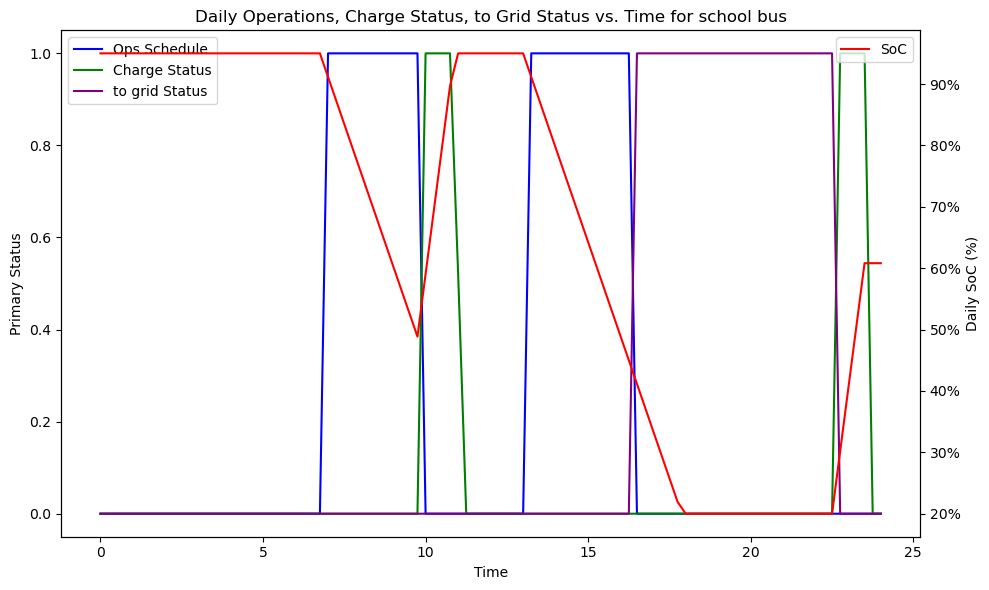

Data successfully exported to V2G_simulated_school_bus_plt1.xlsx


In [229]:
time_ops_bus_t1, ops_schedule_bus_t1,charge_status_bus_t1,battery_energy_level_bus_t1,power_to_grid_bus_t1, to_grid_status_bus_t1= simulate_V2G_optimized(time_ops_bus_t1,ops_schedule_bus_t1,bat_cap_bus_t1,avgspeed_bus_t1,range_bus_t1,Pcharg_bus_t1,min_SoC_bus_t1,max_SoC_bus_t1,interpolated_prices,30)

daily_SoC_bus_t1 = np.array(battery_energy_level_bus_t1)/bat_cap_bus_t1

import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the Operations Schedule, Charge Status, and to Grid Status on the primary y-axis
ax1.plot(time_ops_bus_t1, ops_schedule_bus_t1, label='Ops Schedule', color='blue')
ax1.plot(time_ops_bus_t1, charge_status_bus_t1, label='Charge Status', color='green')
ax1.plot(time_ops_bus_t1, to_grid_status_bus_t1, label='to grid Status', color='purple')

# Set titles and labels for the first y-axis
ax1.set_title('Daily Operations, Charge Status, to Grid Status vs. Time for school bus')
ax1.set_xlabel('Time')
ax1.set_ylabel('Primary Status')

# Display the legend for the first y-axis
ax1.legend(loc='upper left')

# Create a secondary y-axis for the new variable
ax2 = ax1.twinx()

# Plot the new variable (SoC) on the secondary y-axis
ax2.plot(time_ops_bus_t1, daily_SoC_bus_t1, label='SoC', color='red')

# Set the label for the secondary y-axis (SoC in %)
ax2.set_ylabel('Daily SoC (%)')

# Convert SoC ticks to percentages
ax2.set_yticklabels([f'{int(tick*100)}%' for tick in ax2.get_yticks()])

# Set the y-limits of the secondary axis to be between 0 and 1 (representing 0% to 100%)
#ax2.set_ylim(0, 1)

# Display the legend for the secondary y-axis
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


import pandas as pd

# Create a dictionary with the variables
data = {
    "Time (hours)": time_ops_bus_t1,
    "Ops Schedule": ops_schedule_bus_t1,
    "Charge Status": charge_status_bus_t1,
    "To Grid Status": to_grid_status_bus_t1,
    "Daily SoC": daily_SoC_bus_t1,
}

# Convert the dictionary into a pandas DataFrame
df = pd.DataFrame(data)

# Export the DataFrame to an Excel file
output_file = "V2G_simulated_school_bus_plt1.xlsx"
df.to_excel(output_file, index=False)

print(f"Data successfully exported to {output_file}")


In [230]:
V2G_power_bus_t1, gridload_with_V2G_bus_t1 = gridload_with_V2G(smoothed_load,power_to_grid_bus_t1,EVpenetration_bus_t1,n_bus_t1)



#V2G_gain_bus_t1 = calculate_V2G_gain(interpolated_prices,power_to_grid_bus_t1,EVpenetration_bus_t1,n_bus_t1)
#plot_V2Ggain_gridimpact(time_ops_bus_t1,V2G_gain_bus_t1,gridload_with_V2G_bus_t1)
#calculate_net_impact(interpolated_prices,power_to_grid_bus_t1,battery_energy_level_bus_t1,bat_cap_bus_t1,Pcharg_bus_t1, 30,EVpenetration_bus_t1,n_bus_t1,min_SoC_bus_t1,max_SoC_bus_t1)

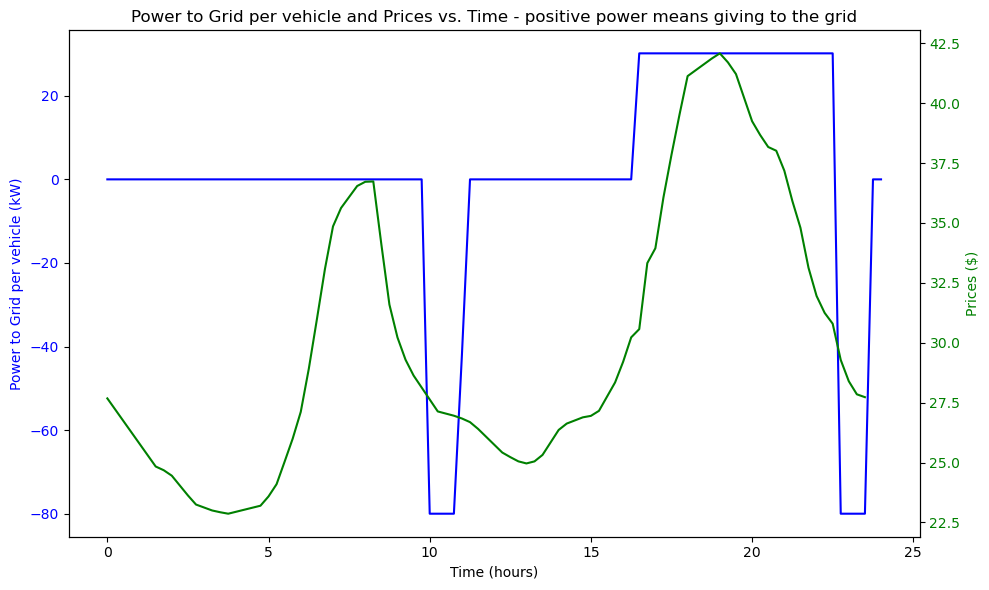

Data successfully exported to V2G_simulated_school_bus_plt2.xlsx


In [231]:
import matplotlib.pyplot as plt

# Plot for power_to_grid and Interpolated Prices with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first variable (power_to_grid)
ax1.plot(time_ops_bus_t1, power_to_grid_bus_t1, label='Power to Grid', color='blue')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Power to Grid per vehicle (kW)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a twin y-axis for the second variable (Interpolated Prices)
ax2 = ax1.twinx()
ax2.plot(time_ops_bus_t1, interpolated_prices, label='Interpolated Prices', color='green')
ax2.set_ylabel('Prices ($)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add a title
plt.title('Power to Grid per vehicle and Prices vs. Time - positive power means giving to the grid')

# Show the plot
plt.tight_layout()  # Ensures the layout doesn't overlap
plt.show()

import pandas as pd

# Create a dictionary with the variables
data = {
    "Time (hours)": time_ops_bus_t1,
    "Interpolated Prices ($)": interpolated_prices,
    "Power to Grid (MW)": power_to_grid_bus_t1,
}

# Convert the dictionary into a pandas DataFrame
df = pd.DataFrame(data)

# Export the DataFrame to an Excel file
output_file = "V2G_simulated_school_bus_plt2.xlsx"
df.to_excel(output_file, index=False)

print(f"Data successfully exported to {output_file}")


In [232]:
V2G_power_bus_t1, gridload_with_V2G_bus_t1 = gridload_with_V2G(smoothed_load,power_to_grid_bus_t1,EVpenetration_bus_t1,n_bus_t1)

calculate_net_impact(interpolated_prices,power_to_grid_bus_t1,battery_energy_level_bus_t1,bat_cap_bus_t1,Pcharg_bus_t1, 30,EVpenetration_bus_t1,n_bus_t1,min_SoC_bus_t1,max_SoC_bus_t1)
print(f'peak shaving = {peak_shaving(gridload_with_V2G_bus_t1, smoothed_load)} in MWatt')

#print(CO2reduction(gridload_with_V2G_bus_t1, smoothed_load))

# import matplotlib.pyplot as plt

# # Plot for Grid Load and Smoothed Load with a secondary y-axis
# fig, ax1 = plt.subplots(figsize=(10, 6))

# # Plot electricity load with V2G and smoothed load on the primary y-axis
# ax1.plot(time_ops_bus_t1, gridload_with_V2G_bus_t1, label='Electricity Load - cumulative power_to_grid', color='blue')
# ax1.plot(time_ops_bus_t1, smoothed_load, label='Electricity Load', color='red', linestyle='--')
# ax1.set_xlabel('Time (hours)')
# ax1.set_ylabel('Load (MW)', color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')

# # Add a legend for the primary y-axis
# ax1.legend(loc='upper left')

# # Create a secondary y-axis for V2G Power
# ax2 = ax1.twinx()
# ax2.plot(time_ops_bus_t1, V2G_power_bus_t1, label='Cumulative Power to Grid', color='green', linestyle='-.')
# ax2.set_ylabel('Cumulative Power to Grid (MW)', color='green')
# ax2.tick_params(axis='y', labelcolor='green')

# # Add a legend for the secondary y-axis
# ax2.legend(loc='upper right')

# # Add a title
# plt.title('Grid Load basedline, Grid Load with V2G, and Cumulative Power to Grid vs. Time')

# # Adjust layout and show the plot
# plt.tight_layout()
# plt.show()

# import pandas as pd

# # Create a dictionary with the variables
# data = {
#     "Time (hours)": time_ops_bus_t1,
#     "Grid Load with V2G (MW)": gridload_with_V2G_bus_t1,
#     "Smoothed Load (MW)": smoothed_load,
#     "V2G Power (MW)": V2G_power_bus_t1,
# }

# # Convert the dictionary into a pandas DataFrame
# df = pd.DataFrame(data)

# # Export the DataFrame to an Excel file
# output_file = "V2G_simulated_school_bus_plt3.xlsx"
# df.to_excel(output_file, index=False)

# print(f"Data successfully exported to {output_file}")



n_units 18989, EV penetration 0.1, n_vehicles = 1898.9
Daily V2G gain per vehicle 0.2917579875161369 $/ vehicle
Daily baseline_cost -4.41 $ / vehicle
Daily V2G value creation for overall fleets 8928.168242494394 $_total
peak shaving = 57.259138461538896 in MWatt


n_units 18989, EV penetration 0.5, n_vehicles = 9494.5
Daily V2G gain per vehicle 0.2917579875161369 $/ vehicle
Daily baseline_cost -4.41 $ / vehicle
Daily V2G value creation for overall fleets 44640.84121247196 $_total


44640.84121247196

C:\Users\haldr\AppData\Local\Temp\ipykernel_41828\2731262519.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([f'{int(tick*100)}%' for tick in ax2.get_yticks()])


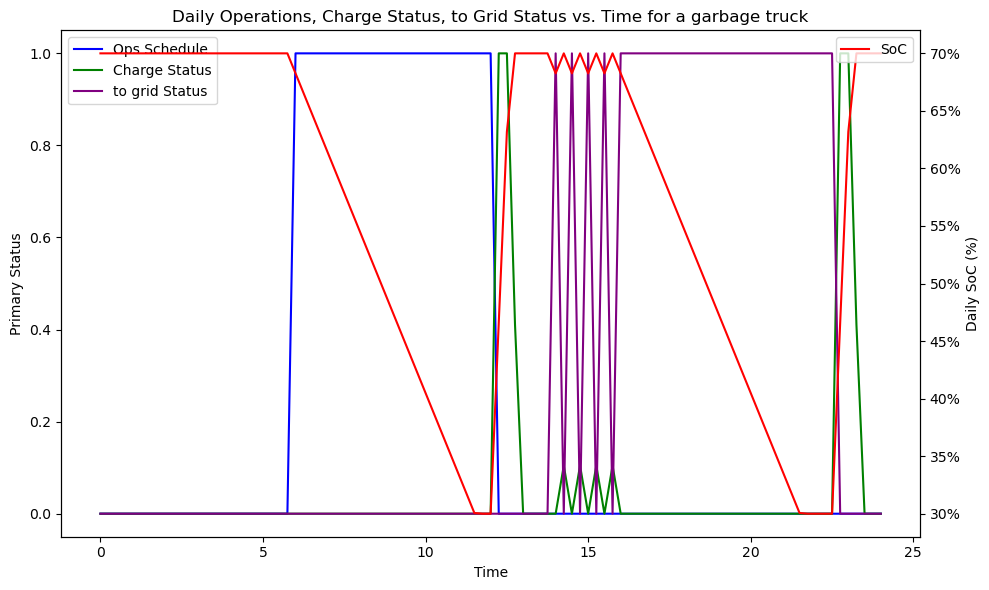

Data successfully exported to V2G_simulated_garbage_plt1.xlsx


In [235]:
time_ops_garbage, ops_schedule_garbage,charge_status_garbage,battery_energy_level_garbage,power_to_grid_garbage, to_grid_status_garbage= simulate_V2G_optimized(time_ops_garbage,ops_schedule_garbage,bat_cap_garbage,avgspeed_garbage,range_garbage,Pcharg_garbage,min_SoC_garbage,max_SoC_garbage,interpolated_prices,30)

daily_SoC_garbage = np.array(battery_energy_level_garbage)/bat_cap_garbage

import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the Operations Schedule, Charge Status, and to Grid Status on the primary y-axis
ax1.plot(time_ops_garbage, ops_schedule_garbage, label='Ops Schedule', color='blue')
ax1.plot(time_ops_garbage, charge_status_garbage, label='Charge Status', color='green')
ax1.plot(time_ops_garbage, to_grid_status_garbage, label='to grid Status', color='purple')

# Set titles and labels for the first y-axis
ax1.set_title('Daily Operations, Charge Status, to Grid Status vs. Time for a garbage truck')
ax1.set_xlabel('Time')
ax1.set_ylabel('Primary Status')

# Display the legend for the first y-axis
ax1.legend(loc='upper left')

# Create a secondary y-axis for the new variable
ax2 = ax1.twinx()

# Plot the new variable (SoC) on the secondary y-axis
ax2.plot(time_ops_garbage, daily_SoC_garbage, label='SoC', color='red')

# Set the label for the secondary y-axis (SoC in %)
ax2.set_ylabel('Daily SoC (%)')

# Convert SoC ticks to percentages
ax2.set_yticklabels([f'{int(tick*100)}%' for tick in ax2.get_yticks()])

# Set the y-limits of the secondary axis to be between 0 and 1 (representing 0% to 100%)
#ax2.set_ylim(0, 1)

# Display the legend for the secondary y-axis
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


import pandas as pd

# Create a dictionary with the variables
data = {
    "Time (hours)": time_ops_garbage,
    "Ops Schedule": ops_schedule_garbage,
    "Charge Status": charge_status_garbage,
    "To Grid Status": to_grid_status_garbage,
    "Daily SoC": daily_SoC_garbage,
}

# Convert the dictionary into a pandas DataFrame
df = pd.DataFrame(data)

# Export the DataFrame to an Excel file
output_file = "V2G_simulated_garbage_plt1.xlsx"
df.to_excel(output_file, index=False)

print(f"Data successfully exported to {output_file}")


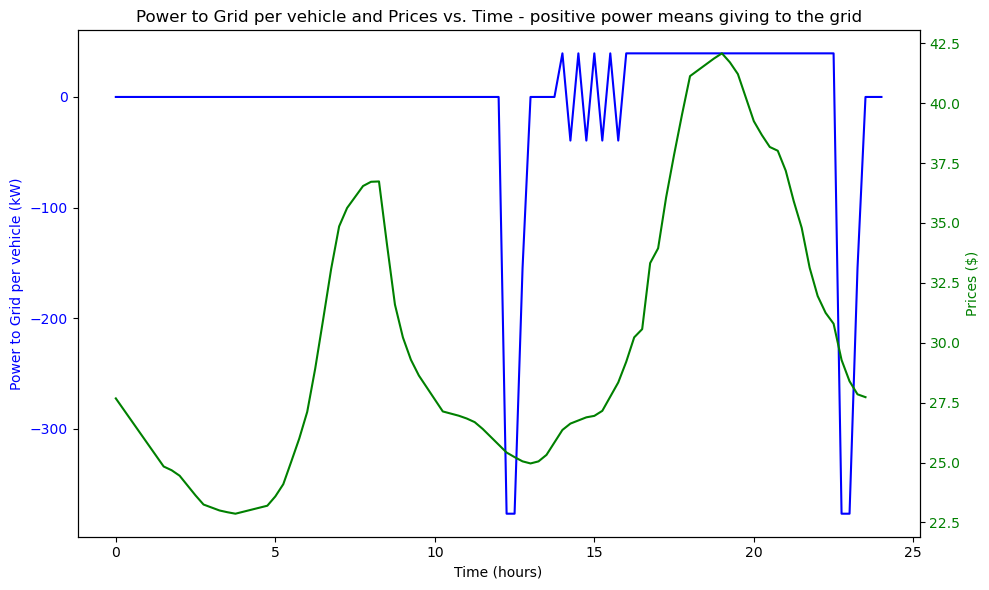

Data successfully exported to V2G_simulated_garbage_plt2.xlsx


In [213]:
import matplotlib.pyplot as plt

# Plot for power_to_grid and Interpolated Prices with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first variable (power_to_grid)
ax1.plot(time_ops_garbage, power_to_grid_garbage, label='Power to Grid', color='blue')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Power to Grid per vehicle (kW)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a twin y-axis for the second variable (Interpolated Prices)
ax2 = ax1.twinx()
ax2.plot(time_ops_garbage, interpolated_prices, label='Interpolated Prices', color='green')
ax2.set_ylabel('Prices ($)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add a title
plt.title('Power to Grid per vehicle and Prices vs. Time - positive power means giving to the grid')

# Show the plot
plt.tight_layout()  # Ensures the layout doesn't overlap
plt.show()

import pandas as pd

# Create a dictionary with the variables
data = {
    "Time (hours)": time_ops_garbage,
    "Interpolated Prices ($)": interpolated_prices,
    "Power to Grid (MW)": power_to_grid_garbage,
}

# Convert the dictionary into a pandas DataFrame
df = pd.DataFrame(data)

# Export the DataFrame to an Excel file
output_file = "V2G_simulated_garbage_plt2.xlsx"
df.to_excel(output_file, index=False)

print(f"Data successfully exported to {output_file}")


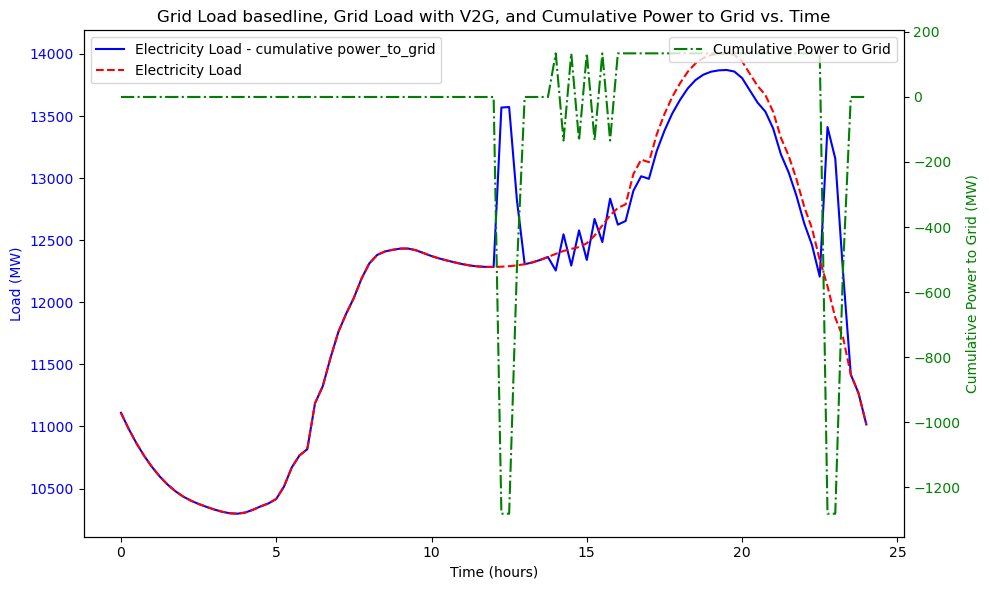

Data successfully exported to V2G_simulated_garbage_plt3.xlsx


In [214]:
V2G_power_garbage, gridload_with_V2G_garbage = gridload_with_V2G(smoothed_load,power_to_grid_garbage,EVpenetration_garbage,n_garbage)

import matplotlib.pyplot as plt

# Plot for Grid Load and Smoothed Load with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot electricity load with V2G and smoothed load on the primary y-axis
ax1.plot(time_ops_garbage, gridload_with_V2G_garbage, label='Electricity Load - cumulative power_to_grid', color='blue')
ax1.plot(time_ops_garbage, smoothed_load, label='Electricity Load', color='red', linestyle='--')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Load (MW)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add a legend for the primary y-axis
ax1.legend(loc='upper left')

# Create a secondary y-axis for V2G Power
ax2 = ax1.twinx()
ax2.plot(time_ops_garbage, V2G_power_garbage, label='Cumulative Power to Grid', color='green', linestyle='-.')
ax2.set_ylabel('Cumulative Power to Grid (MW)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add a legend for the secondary y-axis
ax2.legend(loc='upper right')

# Add a title
plt.title('Grid Load basedline, Grid Load with V2G, and Cumulative Power to Grid vs. Time')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

import pandas as pd

# Create a dictionary with the variables
data = {
    "Time (hours)": time_ops_garbage,
    "Grid Load with V2G (MW)": gridload_with_V2G_garbage,
    "Smoothed Load (MW)": smoothed_load,
    "V2G Power (MW)": V2G_power_garbage,
}

# Convert the dictionary into a pandas DataFrame
df = pd.DataFrame(data)

# Export the DataFrame to an Excel file
output_file = "V2G_simulated_garbage_plt3.xlsx"
df.to_excel(output_file, index=False)

print(f"Data successfully exported to {output_file}")

In [237]:
calculate_net_impact(interpolated_prices,power_to_grid_garbage,battery_energy_level_garbage,bat_cap_garbage,Pcharg_garbage, 30,EVpenetration_garbage,n_garbage,min_SoC_garbage,max_SoC_garbage)
print(f'peak shaving = {peak_shaving(gridload_with_V2G_garbage, smoothed_load)} in MWatt')

n_units 6800, EV penetration 0.1, n_vehicles = 680.0
Daily V2G gain per vehicle -2.4940946723530595 $/ vehicle
Daily baseline_cost -6.816 $ / vehicle
Daily V2G value creation for overall fleets 2938.8956227999192 $_total
peak shaving = 134.13061818181814 in MWatt
